In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# XGBoost with one-hot NAICS 
XGBoost model, one hot encoded NAICS sector

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot 

## Import Processed Datasets

In [6]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [7]:
train_df = sba_loans[sba_loans['dset'] == 'train'].copy()
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

In [8]:
train_df.shape

(436120, 55)

In [9]:
train_df.drop_duplicates('LoanNr_ChkDgt').shape

(436120, 55)

#### Set the predictor features.  Include one-hot NAICS

In [10]:
predictor_features = setup.predictor_features + [c for c in train_df.columns if c.startswith('NS__')]
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'NS___Accommodation and Food Services', 'NS___Administrative and Support and Waste Management and Remediation Services', 'NS___Construction', 'NS___Health Care and Social Assistance', 'NS___Manufacturing', 'NS___Other Services (except Public Administration)', 'NS___Professional, Scientific, and Technical Services', 'NS___Retail Trade', 'NS___Wholesale Trade', 'NS___infrequent_sklearn']


In [11]:
train_df[predictor_features].describe()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,NS___Accommodation and Food Services,NS___Administrative and Support and Waste Management and Remediation Services,NS___Construction,NS___Health Care and Social Assistance,NS___Manufacturing,NS___Other Services (except Public Administration),"NS___Professional, Scientific, and Technical Services",NS___Retail Trade,NS___Wholesale Trade,NS___infrequent_sklearn
count,436120.000000,436120.000000,432893.000000,4.361200e+05,435584.000000,351624.000000,436120.000000,436120.000000,436120.000000,436120.000000,436120.000000,436120.000000,436120.000000,436120.000000,436120.000000,436120.000000,436120.000000
mean,9.723145,2.164835,0.097777,1.944230e+05,0.281016,0.815075,0.052733,0.104930,0.051410,0.096409,0.084023,0.089833,0.104813,0.080063,0.190216,0.068965,0.129338
std,61.690596,11.315009,0.297013,2.989452e+05,0.449496,0.388237,0.223501,0.306463,0.220833,0.295152,0.277422,0.285943,0.306313,0.271391,0.392472,0.253395,0.335574
min,0.000000,0.000000,0.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,3.572600e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,9.000000e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,2.000000,0.000000,2.148528e+05,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9999.000000,3000.000000,1.000000,1.144632e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
train_df[predictor_features + ['target']].corr()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,NS___Accommodation and Food Services,NS___Administrative and Support and Waste Management and Remediation Services,NS___Construction,NS___Health Care and Social Assistance,NS___Manufacturing,NS___Other Services (except Public Administration),"NS___Professional, Scientific, and Technical Services",NS___Retail Trade,NS___Wholesale Trade,NS___infrequent_sklearn,target
NoEmp,1.000000,0.062158,-0.013926,0.095658,-0.041427,0.001610,0.006409,0.014462,0.005095,0.006727,-0.004596,0.044005,-0.015206,-0.010840,-0.021256,0.003478,-0.011293,-0.027403
CreateJob,0.062158,1.000000,-0.062740,0.134686,0.039302,0.009062,0.050517,0.078203,0.001869,-0.009232,-0.004157,0.020165,-0.017586,-0.012573,-0.032883,-0.008557,-0.007133,-0.010002
LowDoc,-0.013926,-0.062740,1.000000,-0.133141,0.153034,-0.120001,0.040841,0.009976,0.001201,-0.028548,0.024883,-0.013266,0.019457,-0.023428,0.043125,-0.026793,-0.023125,-0.079523
DisbursementGross,0.095658,0.134686,-0.133141,1.000000,-0.065443,-0.007016,0.085712,0.072568,-0.059327,-0.042251,0.018609,0.093683,-0.039053,-0.049970,-0.028533,0.059058,-0.020446,-0.120788
new_business,-0.041427,0.039302,0.153034,-0.065443,1.000000,-0.047592,0.137325,0.109894,-0.019128,-0.077699,0.050413,-0.056183,0.027980,-0.034445,0.023308,-0.062550,0.009077,0.013878
urban_flag,0.001610,0.009062,-0.120001,-0.007016,-0.047592,1.000000,-0.006588,-0.024158,0.011619,-0.028348,0.014454,-0.013415,0.020886,0.052913,-0.010011,0.034271,-0.034351,0.053785
franchise_flag,0.006409,0.050517,0.040841,0.085712,0.137325,-0.006588,1.000000,0.273763,0.003841,-0.065668,-0.047940,-0.051414,0.010032,-0.054333,-0.000643,-0.055429,-0.033951,-0.012731
NS___Accommodation and Food Services,0.014462,0.078203,0.009976,0.072568,0.109894,-0.024158,0.273763,1.000000,-0.079709,-0.111839,-0.103700,-0.107567,-0.117158,-0.101008,-0.165943,-0.093186,-0.131965,0.011713
NS___Administrative and Support and Waste Management and Remediation Services,0.005095,0.001869,0.001201,-0.059327,-0.019128,0.011619,0.003841,-0.079709,1.000000,-0.076043,-0.070508,-0.073138,-0.079659,-0.068679,-0.112830,-0.063360,-0.089727,0.016817
NS___Construction,0.006727,-0.009232,-0.028548,-0.042251,-0.077699,-0.028348,-0.065668,-0.111839,-0.076043,1.000000,-0.098930,-0.102620,-0.111770,-0.096363,-0.158311,-0.088901,-0.125896,0.033661


In [13]:
with open(Path(setup.temp_path).joinpath('05_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Fit

In [14]:
best_params_df = pd.read_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

##### Fit using pre-determined parameters

In [15]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [16]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators = setup.xgb_n_estimators)

In [17]:
xgb_model = xgb_model.set_params(**xgb_params)

In [18]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.50188	validation_1-logloss:0.50530
[1]	validation_0-logloss:0.49556	validation_1-logloss:0.49903
[2]	validation_0-logloss:0.49030	validation_1-logloss:0.49385
[3]	validation_0-logloss:0.48568	validation_1-logloss:0.48930
[4]	validation_0-logloss:0.48186	validation_1-logloss:0.48556
[5]	validation_0-logloss:0.47847	validation_1-logloss:0.48222
[6]	validation_0-logloss:0.47561	validation_1-logloss:0.47942
[7]	validation_0-logloss:0.47321	validation_1-logloss:0.47708
[8]	validation_0-logloss:0.47109	validation_1-logloss:0.47503
[9]	validation_0-logloss:0.46932	validation_1-logloss:0.47333
[10]	validation_0-logloss:0.46773	validation_1-logloss:0.47182
[11]	validation_0-logloss:0.46631	validation_1-logloss:0.47047
[12]	validation_0-logloss:0.46512	validation_1-logloss:0.46934
[13]	validation_0-logloss:0.46410	validation_1-logloss:0.46837
[14]	validation_0-logloss:0.46319	validation_1-logloss:0.46756
[15]	validation_0-logloss:0.46242	validation_1-logloss:0.46684
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [19]:
train_df['target'].value_counts()

target
0    346866
1     89254
Name: count, dtype: int64

##### Save the model

In [20]:
xgb_model.save_model(Path(setup.temp_path).joinpath('05_MODEL_xgboost.json'))

In [21]:
with open(Path(setup.temp_path).joinpath('05_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [22]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [23]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.187792,0.108479,0.01637,0.663749,0.182601
1,0.271903,0.093979,0.01637,0.683506,0.290298


## Decision Threshold
Max f1, on training data

In [24]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [25]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [26]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('05_REPORT_thresh_tune.csv'), index=False)

In [27]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.22


,thresh,f1
11,0.22,0.440351
12,0.24,0.439662


##### Apply decision threshold
All datasets

In [28]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [29]:
pred_df['predict_bin'].value_counts()

predict_bin
0    357566
1    330515
Name: count, dtype: int64

In [30]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('05_DATA_combined_predictions.parquet'))

## Metrics

In [31]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('05_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.624881,0.432973,0.307531,0.731252,0.355820,0.722092,NaN
1,train,0.614377,0.440351,0.313199,0.741300,0.363523,0.716353,NaN
2,val,0.610932,0.439200,0.313295,0.734296,0.364549,0.712160,NaN
0,test,0.611086,0.439001,0.312104,0.739791,0.358867,0.713595,0.0
1,test,0.644700,0.423228,0.300156,0.717367,0.350732,0.733087,1.0


## Lift
Test data

In [32]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

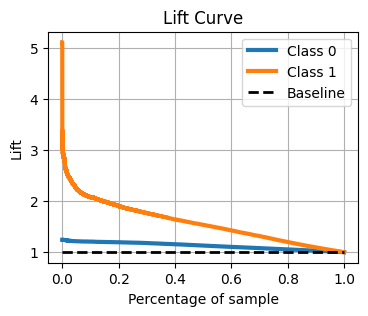

In [33]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('05_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [34]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [35]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('05_REPORT_importance_gain.csv'), index=True)

In [36]:
feat_impgain.head()

,importance
urban_flag,696.576416
LowDoc,153.650986
DisbursementGross,74.793709
NS___Health Care and Social Assistance,63.256439
new_business,25.414274


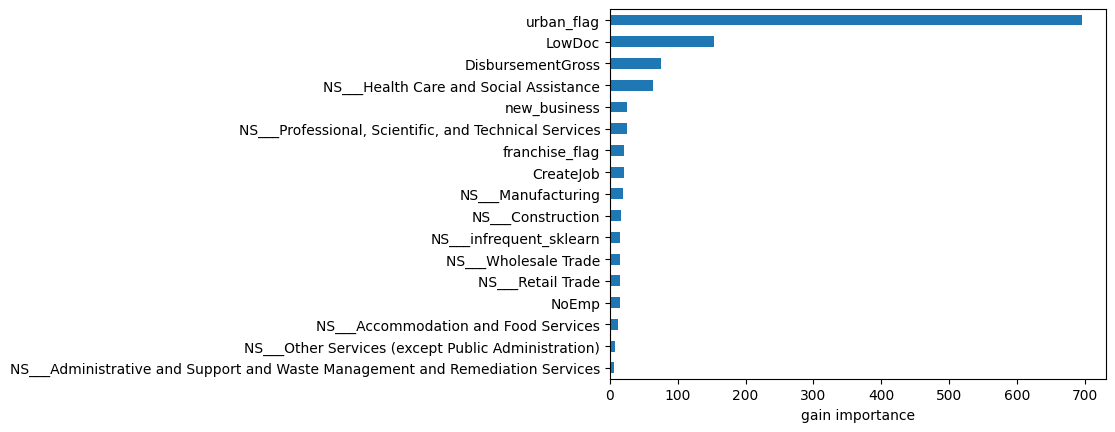

In [37]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('05_PLOT_importance_gain.png'))

##### Permutation Importance

In [38]:
perm_importance = permutation_importance(xgb_model, 
                                         train_df[predictor_features],  train_df['target'],
                                         n_repeats=30, scoring = 'average_precision')

In [39]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [40]:
perm_importance_df.head(5)

,features,importance,abs_importance
3,DisbursementGross,0.088143,0.088143
5,urban_flag,0.048297,0.048297
1,CreateJob,0.030702,0.030702
2,LowDoc,0.015892,0.015892
0,NoEmp,0.013535,0.013535


In [41]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('05_DATA_importance_perturb.csv'),
            index=False)

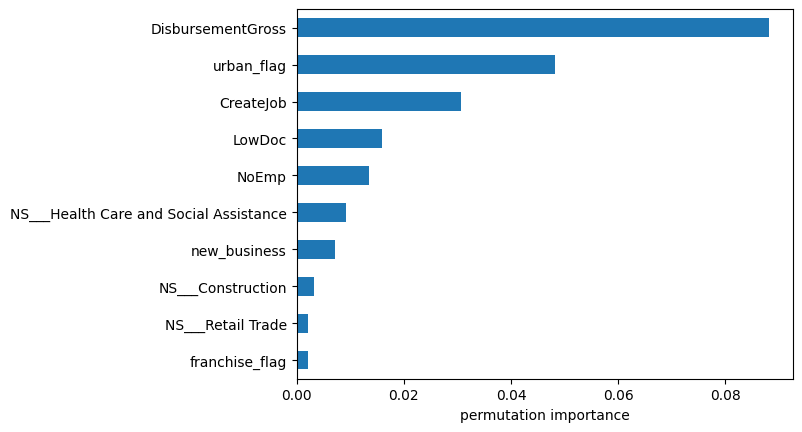

In [42]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('05_PLOT_importance_perturb.png'))

## PDP Plot - NAICS one hot

In [43]:
naics_features = list(train_df.filter(like='NS__').columns)

In [44]:
plt.close()

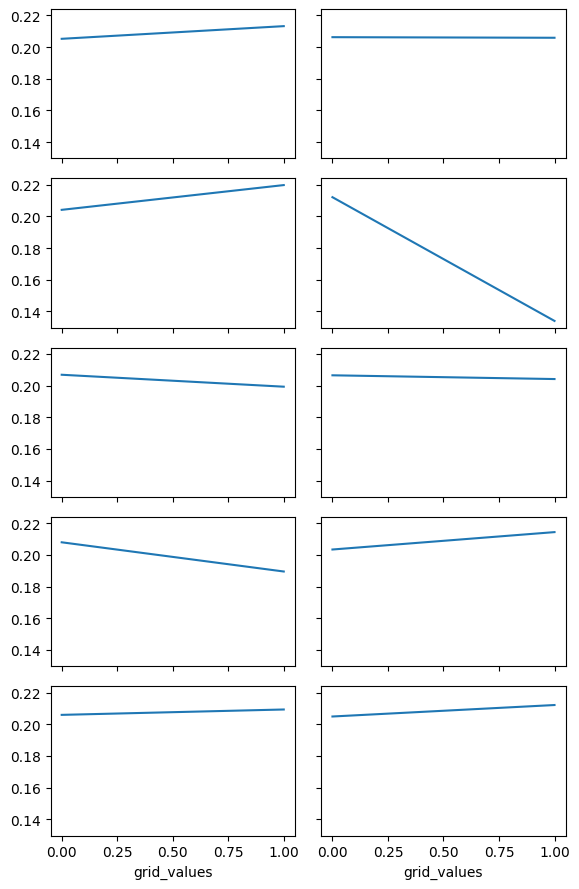

In [45]:
fig, ax = plt.subplots(int(np.ceil(len(naics_features)/2)), 2, sharex=True, sharey=True, figsize=(6, 9))
for i in range(len(naics_features)):
    col = int(i % 2)
    row = int(np.floor(i / 2))
    results = partial_dependence(xgb_model, train_df[predictor_features], 
                                 [naics_features[i]])
    pdp_df = pd.DataFrame({'grid_values':results["grid_values"][0],
                       'pdp':results["average"][0]})
    pdp_df.plot(x='grid_values', y='pdp', legend=None, ax=ax[row, col])

fig.tight_layout()
fig.savefig(Path(setup.temp_path).joinpath('05_PLOT_pdp_naics_onehot.png'),
               bbox_inches='tight')
plt.show()